In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from scipy.optimize import minimize, basinhopping
from sklearn import preprocessing
from sklearn.covariance import LedoitWolf, EmpiricalCovariance, ShrunkCovariance, OAS, GraphLassoCV, MinCovDet, GraphLasso
import empyrical
%matplotlib inline

In [170]:
DATA_DIR = 'D:/workspace/zjsxzy_in_js/Research/data/'

In [171]:
fname = '%s/assets.xlsx'%(DATA_DIR)

In [172]:
odf = pd.read_excel(fname, index_col=0)

In [173]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE,B.IPE,H11025.CSI,CCFI.WI
2018-07-18,3813.5347,28117.42,2815.62,181.2749,265.47,73.06,1488.7237,1065.4121
2018-07-19,3792.2334,28010.86,2804.49,181.4888,266.29,72.70,1488.8743,1079.6532
2018-07-20,3851.2965,28224.48,2801.83,181.4993,267.48,73.07,1489.0281,1082.2548
2018-07-23,3883.1899,28256.12,2806.98,181.5767,268.40,73.26,1489.4725,1091.8285
2018-07-24,3945.4412,28662.57,2820.40,181.4481,268.43,74.15,1489.6274,1091.1258


In [174]:
 # 风险预算优化
def calculate_portfolio_var(w, V):
    # 计算组合风险的函数
    return w.dot(V).dot(w)
def calculate_risk_contribution(w ,V):
    # 边际风险贡献
    MRC = V.dot(w)
    # 风险贡献
    RC = w * MRC
    return RC
def risk_budget_objective(x, pars):
    # 计算组合风险
    V = pars[0]# 协方差矩阵
    MRC = V.dot(x)
    ARC = x * MRC
    J = np.sum([(i-j)**2 for i in ARC for j in ARC])
#     J = x.dot(MRC) - np.log(x).sum()
#     J = calculate_portfolio_var(x, V) - np.log(x).sum()
#     J = sum(np.square(asset_RC - risk_target.T))[0, 0] # sum of squared error
#     J = np.abs(asset_RC.max() - asset_RC.min())
    return J
def total_weight_constraint(x):
    return np.sum(x) - 1.0
def long_only_constraint(x):
    return x
def vol_constraint(x):
    return np.concatenate((x, np.array([np.sqrt(calculate_portfolio_var(x, cov)) - 0.002])))
# 根据资产预期目标风险贡献度来计算各资产的权重
def calcu_w(V):
    N = V.shape[0]
    w0 = np.random.random_sample((N,))
    w0 /= w0.sum()
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
            {'type': 'ineq', 'fun': long_only_constraint})
    minimizer_args = {'method': 'SLSQP', 'args': [V], 'constraints': cons}
#     minimizer_args = {'method': 'L-BFGS-B', 'args': [V], 'bounds': np.array([(0., None)]*N)}
#     weight = res.x / res.x.sum()
    res = basinhopping(risk_budget_objective, w0, stepsize=1e-8, minimizer_kwargs=minimizer_args)
#     res = minimize(risk_budget_objective, w0, args=[V], method='SLSQP',constraints=cons)
    return res.x

In [175]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [176]:
df = odf[['881001.WI', 'CBA00101.CS', 'CCFI.WI']]

In [177]:
df = df.replace([0], np.NAN)

In [178]:
ret_df = df.pct_change().dropna()

In [179]:
ret_df.head()

,881001.WI,CBA00101.CS,CCFI.WI
2002-01-07,-0.011381,0.000418,0.000000
2002-01-08,-0.008333,-0.001876,0.027092
2002-01-09,-0.018304,0.001933,0.001645
2002-01-10,0.008978,-0.000886,-0.002444
2002-01-11,-0.027818,0.003406,0.000065


In [180]:
cov = ret_df.cov()

In [181]:
w = np.array([1. / ret_df.shape[1]] * ret_df.shape[1])

In [182]:
rc = calculate_risk_contribution(w, cov)

In [183]:
rc

881001.WI      4.127134e-05
CBA00101.CS    7.562051e-08
CCFI.WI        2.474682e-05
dtype: float64

In [184]:
wb = calcu_w(cov*10000)

In [185]:
wb

array([0.04941135, 0.88061282, 0.06997581])

In [186]:
rc = calculate_risk_contribution(wb, cov)

In [187]:
rc

881001.WI      9.628910e-07
CBA00101.CS    1.000774e-06
CCFI.WI        9.736575e-07
dtype: float64

In [188]:
np.sqrt(calculate_portfolio_var(wb, cov))

0.0017138618368660974

# 回测

In [189]:
months = pd.Series(['%s-%s'%(x.year, x.month) for x in ret_df.index.tolist()], index=ret_df.index)
months = months[months.str.contains('-6') | months.str.contains('-12')]
rebalance_dates = months.drop_duplicates(keep='last').index

In [190]:
rebalance_dates

DatetimeIndex(['2002-06-28', '2002-12-31', '2003-06-30', '2003-12-31',
               '2004-06-30', '2004-12-31', '2005-06-30', '2005-12-30',
               '2006-06-30', '2006-12-29', '2007-06-29', '2007-12-28',
               '2008-06-30', '2008-12-31', '2009-06-30', '2009-12-31',
               '2010-06-30', '2010-12-31', '2011-06-30', '2011-12-30',
               '2012-06-29', '2012-12-31', '2013-06-28', '2013-12-31',
               '2014-06-30', '2014-12-31', '2015-06-30', '2015-12-31',
               '2016-06-30', '2016-12-30', '2017-06-30', '2017-12-29',
               '2018-06-29'],
              dtype='datetime64[ns]', freq=None)

In [191]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.array([0.] * ret_df.shape[1])
for date in ret_df.index[:-121]:
    weight.loc[date] = wb
    if date in rebalance_dates:
        print date
        cov = ret_df[ret_df.index >= date][:121].cov()
        wb = calcu_w(cov*10000)

2002-06-28 00:00:00
2002-12-31 00:00:00
2003-06-30 00:00:00
2003-12-31 00:00:00
2004-06-30 00:00:00
2004-12-31 00:00:00
2005-06-30 00:00:00
2005-12-30 00:00:00
2006-06-30 00:00:00
2006-12-29 00:00:00
2007-06-29 00:00:00
2007-12-28 00:00:00
2008-06-30 00:00:00
2008-12-31 00:00:00
2009-06-30 00:00:00
2009-12-31 00:00:00
2010-06-30 00:00:00
2010-12-31 00:00:00
2011-06-30 00:00:00
2011-12-30 00:00:00
2012-06-29 00:00:00
2012-12-31 00:00:00
2013-06-28 00:00:00
2013-12-31 00:00:00
2014-06-30 00:00:00
2014-12-31 00:00:00
2015-06-30 00:00:00
2015-12-31 00:00:00
2016-06-30 00:00:00
2016-12-30 00:00:00
2017-06-30 00:00:00
2017-12-29 00:00:00


In [192]:
weight = weight.fillna(method='ffill')

In [193]:
port_ret = (weight * ret_df).sum(axis=1)

In [194]:
money_ret = odf['H11025.CSI'].replace([0.], np.NAN).pct_change().dropna()
bond_ret = odf['CBA00101.CS'].replace([0.], np.NAN).pct_change().dropna()

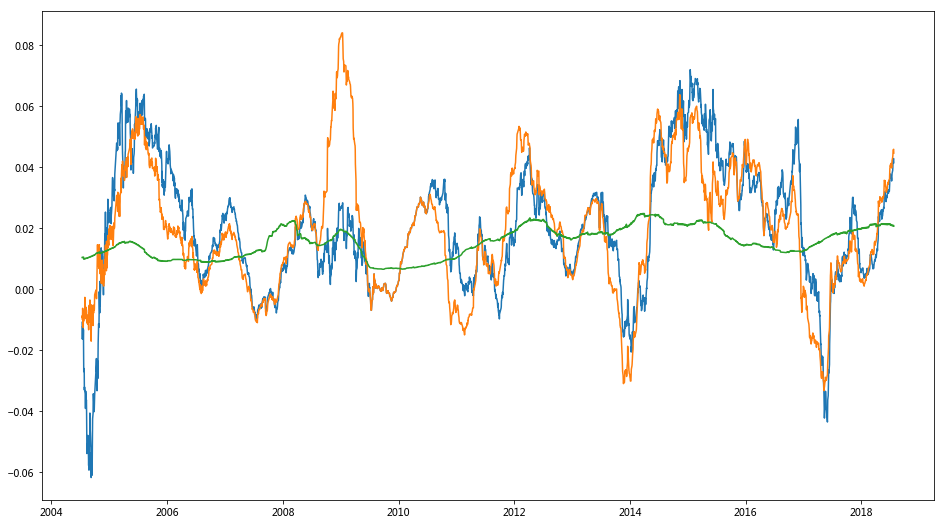

In [213]:
plt.figure(figsize=(16, 9))
plt.plot(port_ret[port_ret.index >= money_ret.index[0]].rolling(121).apply(lambda x: empyrical.cum_returns_final(x)))
plt.plot(bond_ret[bond_ret.index >= money_ret.index[0]].rolling(121).apply(lambda x: empyrical.cum_returns_final(x)))
plt.plot(money_ret.rolling(121).apply(lambda x: empyrical.cum_returns_final(x)))

In [206]:
diff_ret = port_ret[port_ret.index >= money_ret.index[0]].rolling(121).apply(lambda x: empyrical.cum_returns_final(x)) - \
           money_ret.rolling(121).apply(lambda x: empyrical.cum_returns_final(x))
diff_bond_ret = bond_ret.rolling(121).apply(lambda x: empyrical.cum_returns_final(x)) - \
                money_ret.rolling(121).apply(lambda x: empyrical.cum_returns_final(x))

<BarContainer object of 3534 artists>

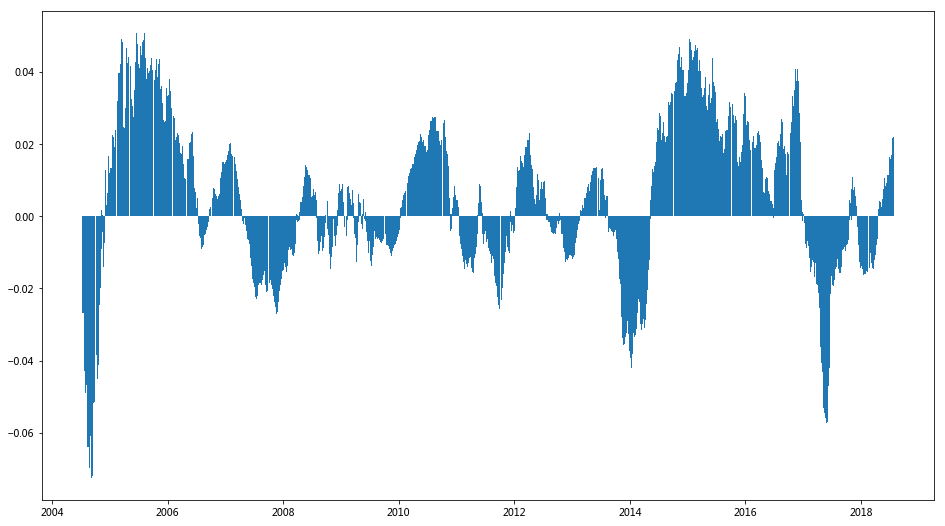

In [209]:
plt.figure(figsize=(16, 9))
plt.bar(diff_ret.index, diff_ret, width=5)
# plt.bar(diff_bond_ret.index, diff_bond_ret, width=5)

In [205]:
diff_ret.to_excel('./risk premium.xlsx')

In [155]:
diff_ret = (port_ret[port_ret.index >= '2018-01-01'].replace([0.], np.NAN) - money_ret[money_ret.index >= '2018-01-01'])

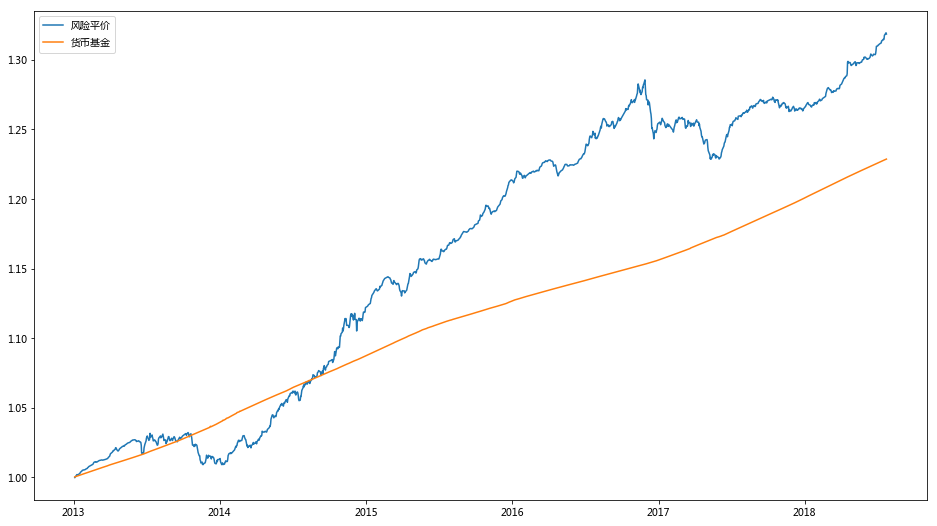

In [158]:
fig = plt.figure(figsize=(16, 9))
plt.plot((1 + port_ret[port_ret.index >= '2013-01-01']).cumprod(), label=u'风险平价')
plt.plot((1 + money_ret[money_ret.index >= '2013-01-01']).cumprod(), label=u'货币基金')
# plt.plot((1 + bond_ret[bond_ret.index >= money_ret.index[0]]).cumprod(), label=u'债券')
# plt.plot((1 + diff_ret).cumprod())
plt.legend()

In [151]:
metric(port_ret)

Annual return: 3.55%
Sharpe ratio: 1.55
Annual volatility: 2.26%
Max drawdown: -6.34%


# 每半年收益风险比

In [165]:
sharpe = pd.Series(index=port_ret.index)
for date in port_ret.index:
    if date in rebalance_dates:
        sharpe.loc[date] = empyrical.sharpe_ratio(port_ret[port_ret.index <= date][-121:])

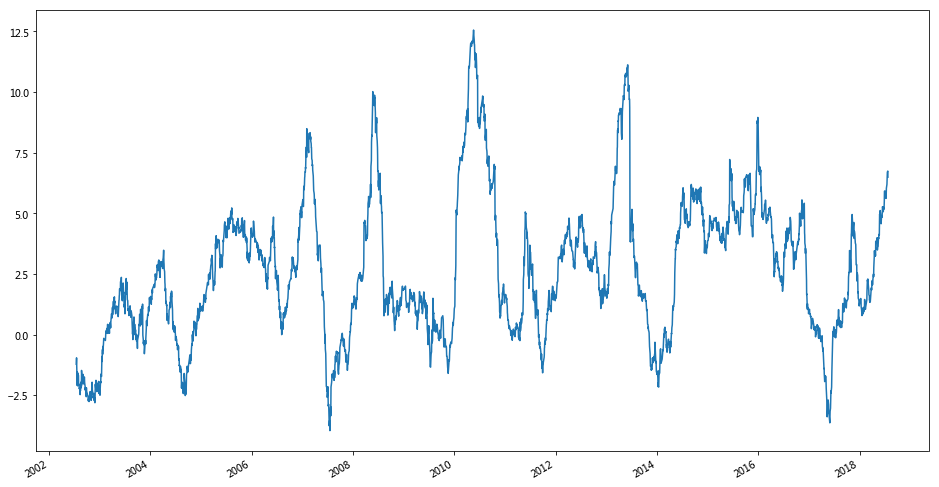

In [211]:
port_ret.rolling(121).apply(lambda x: empyrical.sharpe_ratio(x)).plot(figsize=(16, 9))